## 1. Standard Import

In [1]:
from IPython import display

import matplotlib_inline.backend_inline

matplotlib_inline.backend_inline.set_matplotlib_formats('svg')

In [2]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

In [3]:
import torch
import torch.nn as nn
import torch.nn.functional  as F
from scipy.signal import convolve2d

In [4]:
# for getting summary info on models
from torchsummary import summary

In [5]:
from torch.utils.data import DataLoader,TensorDataset
from sklearn.model_selection import train_test_split

## 2. Import the data

In [6]:
# import dataset (comes with colab!)
data = pd.read_csv("CIFAR10_train.csv", )

In [7]:
data.head()

,pixel_0,pixel_1,pixel_2,pixel_3,pixel_4,pixel_5,pixel_6,pixel_7,pixel_8,pixel_9,...,pixel_3063,pixel_3064,pixel_3065,pixel_3066,pixel_3067,pixel_3068,pixel_3069,pixel_3070,pixel_3071,label
0,59,43,50,68,98,119,139,145,149,149,...,58,65,59,46,57,104,140,84,72,6
1,154,126,105,102,125,155,172,180,142,111,...,42,67,101,122,133,136,139,142,144,9
2,255,253,253,253,253,253,253,253,253,253,...,83,80,69,66,72,79,83,83,84,9
3,28,37,38,42,44,40,40,24,32,43,...,39,59,42,44,48,38,28,37,46,4
4,170,168,177,183,181,177,181,184,189,189,...,88,85,82,83,79,78,82,78,80,1


In [8]:
data["label"].value_counts()

6    5000
9    5000
4    5000
1    5000
2    5000
7    5000
8    5000
3    5000
5    5000
0    5000
Name: label, dtype: int64

#### Classes:

    1) 0: airplane
    2) 1: automobile
    3) 2: bird
    4) 3: cat
    5) 4: deer
    6) 5: dog
    7) 6: frog
    8) 7: horse
    9) 8: ship
    10) 9: truck

In [9]:
# Sampling
#data = data.sample(20000, random_state=123)

data = data.to_numpy()

# Extracting only the first 8
labels = data[:,-1]
data   = data[:,:-1]

# normalize the data to a range of [0 1]
# Although T.ToTensor() will internally do the Min-Max scaling
data = data / np.max(data)



#### Reshaping

In [11]:
# Since the input images were color (input_channels=3(RGB))

# number of images : data.shape[0]
# number of input channel : 3

# height : 32
# width :  32
# Total number of pixels = columns = 3*32*32 = 3072
data = data.reshape(data.shape[0],3,32,32)

In [12]:
# check sizes
print(data.shape)
print(labels.shape)

(50000, 3, 32, 32)
(50000,)


#### Visualizing some images

In [21]:
Classes_dict = {
 0: 'airplane' ,
 1: 'automobile' ,
 2: 'bird' ,
 3: 'cat' ,
 4: 'deer' ,
 5: 'dog' ,
 6: 'frog' ,
 7: 'horse' ,
 8: 'ship' , 
 9: 'truck' }

In [22]:
Classes_dict[0]

'airplane'

In [23]:
labels

array([6, 9, 9, ..., 9, 1, 1], dtype=int64)

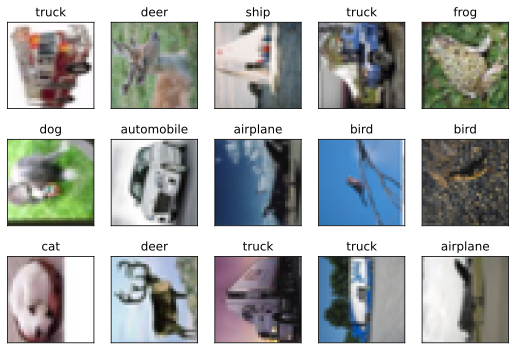

In [25]:
# visualize some images
fig,axs = plt.subplots(3,5,figsize=(9,6), dpi=135)

for i,ax in enumerate(axs.flatten()):

    # pick a random pic
    whichpic = np.random.randint(data.shape[0])

    # extract the image and its target letter
    I = np.squeeze( data[whichpic,:,:] )
#     print(labels[whichpic])
    classes = Classes_dict[labels[whichpic]]

    # visualize
    ax.imshow(I.T,cmap='gray')
    ax.set_title(f'{classes}')
    ax.set_xticks([])
    ax.set_yticks([])

plt.show()

## 3. Create DataLoader

#### (i) convert to tensor

In [26]:
dataT   = torch.tensor( data ).float()
labelsT = torch.tensor( labels ).long()

#### (ii) Train-Test split

In [27]:
train_data,test_data, train_labels,test_labels = train_test_split(dataT, labelsT, test_size=.15)

#### (iii) Convert into PyTorch Datasets

In [28]:
train_dataset = TensorDataset(train_data,train_labels)
test_dataset  = TensorDataset(test_data,test_labels)

#### (iv) Translate into dataloader objects

In [29]:
batchsize    = 32

train_loader = DataLoader(train_dataset, batch_size=batchsize, shuffle=True, drop_last=True)
test_loader  = DataLoader(test_dataset,  batch_size=test_dataset.tensors[0].shape[0])

In [30]:
# check size (should be No. of images x No. of channels x width X height)
train_loader.dataset.tensors[0].shape

torch.Size([42500, 3, 32, 32])

In [31]:
dataT.shape

torch.Size([50000, 3, 32, 32])

In [32]:
dataT.shape.numel()

153600000

In [33]:
dataT.shape[0]

50000

In [34]:
dataT.shape.numel()/dataT.shape[0]

3072.0

## 4. Create the DL model

In [35]:
# create a class for the model
def createCIFAR10Net(LR, printtoggle=False):

    class CIFARNet(nn.Module):
        
        def __init__(self,printtoggle):
            super().__init__()

            ### convolution layers
            # 1:in_channels (gray scale) , 10:out_channels, stride=1 (No striding)
            self.conv1 = nn.Conv2d(in_channels=3,out_channels=10,kernel_size=3,stride=1,padding=1)
            # since, it's a square image, therefore row_size = column_size
            # size: np.floor( (32+2*1-3)/1 )+1 = 32/2 = 16 (/2 because maxpool)

            self.conv2 = nn.Conv2d(10,20,kernel_size=3,stride=1,padding=1)
            # size: np.floor( (16+2*1-3)/1 )+1 = 16/2 = 8 (/2 because maxpool)

            # compute the number of units in FClayer (number of outputs of conv2)
            # fc1 layer has no padding or kernel, so set to padding=0 and stride=1
            #expectSize = np.floor( (5+2*0-1)/1 ) + 1 
            # Since, it's a square image, therefore num_pixels_rows = num_pixels_cols
            # otherwise, we'll have to calculate 'expectSize' for rows and columns separately
            # 20:out_channels from conv2 layer
            # expectSize = 20*int(expectSize**2)
            # expectSize : indicating number if input features per image

            ### fully-connected layer
            # 50 : number of Neurons
            #self.fc1 = nn.Linear(expectSize,50)
            self.fc1 = nn.Linear(20*8*8, 50)
            
            
            ### Output layer
            self.out = nn.Linear(50,10)

            # toggle for printing out tensor sizes during forward prop
            self.print = printtoggle

        # forward pass
        def forward(self,x):

            print(f'Input: {x.shape}') if self.print else None

            # convolution -> maxpool -> relu
            # 2 : pooling window_size
            x = F.relu( F.max_pool2d( self.conv1(x), 2) )
            print(f'Layer conv1-->pool1: {x.shape}') if self.print else None

            # and again: convolution -> maxpool -> relu
            x = F.relu( F.max_pool2d( self.conv2(x), 2) )
            print(f'Layer conv2-->pool2: {x.shape}') if self.print else None

            # reshape for linear layer
            # torch.numel(input) : Returns the total number of elements in the input tensor.
            nUnits = x.shape.numel()/x.shape[0]

            # Reshaping
            x = x.view(-1,int(nUnits))

            if self.print: print(f'Vectorize : {x.shape}')

            # linear layers
            x = F.relu( self.fc1(x) )
            if self.print: print(f'Layer fc1: {x.shape}')

            x = self.out(x)
            if self.print: print(f'Layer out: {x.shape}')

            return x
  
    # create the model instance
    model = CIFARNet(printtoggle)

    # loss function
    lossfunc = nn.CrossEntropyLoss()

    # optimizer
    optimizer = torch.optim.Adam(model.parameters(),lr=LR)

    return model, lossfunc, optimizer

In [37]:
# test the model with one batch
test_net, test_lossfun, test_optimizer = createCIFAR10Net(LR=0.001,printtoggle=True)

X,y = next(iter(train_loader))
yHat_test = test_net(X)

# check sizes of model outputs and target variable
print(' ')
print("yhat shape : ", yHat_test.shape)
print("y shape : ",y.shape)

# now let's compute the loss
loss = test_lossfun(yHat_test,y)
print(' ')
print('Loss:')
print(loss)

# 32 : batch size

Input: torch.Size([32, 3, 32, 32])
Layer conv1-->pool1: torch.Size([32, 10, 16, 16])
Layer conv2-->pool2: torch.Size([32, 20, 8, 8])
Vectorize : torch.Size([32, 1280])
Layer fc1: torch.Size([32, 50])
Layer out: torch.Size([32, 10])
 
yhat shape :  torch.Size([32, 10])
y shape :  torch.Size([32])
 
Loss:
tensor(2.3138, grad_fn=<NllLossBackward0>)


#### Using summary function of pytorch

In [39]:
# count the total number of parameters in the model

summary(test_net,(3,32,32)) ;

Input: torch.Size([2, 3, 32, 32])
Layer conv1-->pool1: torch.Size([2, 10, 16, 16])
Layer conv2-->pool2: torch.Size([2, 20, 8, 8])
Vectorize : torch.Size([2, 1280])
Layer fc1: torch.Size([2, 50])
Layer out: torch.Size([2, 10])
Layer (type:depth-idx)                   Output Shape              Param #
├─Conv2d: 1-1                            [-1, 10, 32, 32]          280
├─Conv2d: 1-2                            [-1, 20, 16, 16]          1,820
├─Linear: 1-3                            [-1, 50]                  64,050
├─Linear: 1-4                            [-1, 10]                  510
Total params: 66,660
Trainable params: 66,660
Non-trainable params: 0
Total mult-adds (M): 0.80
Input size (MB): 0.01
Forward/backward pass size (MB): 0.12
Params size (MB): 0.25
Estimated Total Size (MB): 0.38


## 5. Model Training

In [40]:
def function2trainTheModel(Model, lossfunc, optimizer, train_loader, test_loader, epochs):

    losses   = torch.zeros(epochs)
    trainAcc = []
    testAcc  = []

    # loop over epochs
    for epochi in range(epochs):

        # switch on training mode
        Model.train()

        # loop over training data batches
        batchAcc  = []
        batchLoss = []
    
        # Batch Training
        for X,y in train_loader:

            # Forward pass and loss
            yHat_train = Model(X)
            loss = lossfunc(yHat_train,y)

            # Backprop
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            # Loss from this batch
            batchLoss.append(loss.item())

            # Compute accuracy
            matches = torch.argmax(yHat_train,axis=1) == y     # booleans (false/true)
            matchesNumeric = matches.float()             # convert to numbers (0/1)
            accuracyPct = 100*torch.mean(matchesNumeric) # average and x100 
            batchAcc.append( accuracyPct )               # add to list of accuracies
        # End of batch loop...

        # Now that we've trained through the batches, get their average training accuracy
        trainAcc.append( np.round(np.mean(batchAcc),2 ))

        # Get average losses across the batches
        losses[epochi] = np.round(np.mean(batchLoss),2)

        # test accuracy
        Model.eval()
        X,y = next(iter(test_loader)) # extract X,y from test dataloader
        with torch.no_grad():         # deactivates autograd
            yHat_test = Model(X)
      
        # compare the following really long line of code to the training accuracy lines
        testAcc.append( np.round(100*torch.mean((torch.argmax(yHat_test,axis=1)==y).float()),2 ) )
        # End epochs

    # function output
    return trainAcc,testAcc,losses,Model

## 6.  Run the model 

In [41]:
CNN_model,lossfunc,optimizer = createCIFAR10Net(LR=0.001, printtoggle=False)

In [42]:
# Took 15mins 
TrainAcc,TestAcc,Losses,trained_Model=function2trainTheModel(Model=CNN_model , 
                                                             lossfunc=lossfunc , 
                                                             optimizer=optimizer,
                                                             train_loader=train_loader , 
                                                             test_loader=test_loader, 
                                                             epochs=25)

## 7. Results Visualization

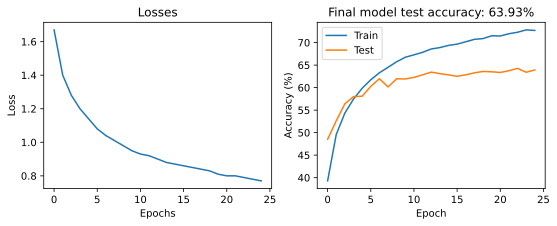

In [43]:
fig,ax = plt.subplots(1,2,figsize=(9,3))

ax[0].plot(Losses.detach())
ax[0].set_ylabel('Loss')
ax[0].set_xlabel('Epochs')
ax[0].set_title('Losses')

ax[1].plot(TrainAcc,label='Train')
ax[1].plot(TestAcc, label='Test')
ax[1].set_ylabel('Accuracy (%)')
ax[1].set_xlabel('Epoch')
ax[1].set_title(f'Final model test accuracy: {TestAcc[-1]:.2f}%')
ax[1].legend()

plt.show()